In [1]:
from datetime import datetime
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql import DataFrame
import matplotlib.pyplot as plt
from datapipeline_konfio.extractor.extractor_coingecko import ExtractorCoinGecko

# Extracción 

In [2]:
def extraction_process(
    spark: SparkSession, date_range: dict, api_demo_value: str, coint_to_search: str
)->DataFrame:

    obj_extractor = ExtractorCoinGecko(
        spark, date_range, api_demo_value, coint_to_search
    )
    df_spark = obj_extractor.extract_data_from_source()

    return df_spark

# Transformación 

In [3]:
def transform_process(df_spark: DataFrame) -> DataFrame:

    df_spark = df_spark.dropDuplicates()

    window_spec = Window.partitionBy("symbol").orderBy("date").rowsBetween(-4, 0)

    df_spark = df_spark.withColumn(
        "moving_avg_5d", F.avg("price_usd").over(window_spec)
    )

    df_spark = df_spark.orderBy("date")

    return df_spark

# Carga

In [4]:
def load_process(df_spark: DataFrame) -> DataFrame:

    # =======================Guardado en la base de datos postgresql=======================START
    
    (
        df_spark.write \
        .format("jdbc") \
        .option("url", "jdbc:postgresql://postgres:5432/db_konfio") \
        .option("dbtable", "tbl_coint_price") \
        .option("user", "konfio") \
        .option("password", "1234") \
        .option("driver", "org.postgresql.Driver") \
        .mode("overwrite")
        .save()
    )

    # =======================Guardado en la base de datos postgresql=======================END

    # =======================Guardado en iceberg=======================START
    
    (
        df_spark
        .write \
        .format("iceberg") \
        .mode("overwrite") \
        .saveAsTable("local.db.tbl_coint_price")
    )

    # =======================Guardado en iceberg=======================END
    

In [5]:
if __name__ == "__main__":

    POSTGRESQL_JAR = "/home/jovyan/work/drivers/postgresql-42.2.18.jar"
    ICEBERG_JAR = "/home/jovyan/work/drivers/iceberg-spark-runtime-3.3_2.12-1.4.2.jar"
    API_DEMO_VALUE = "CG-ioYW4FevLL58FGqWBWpym6GW"
    COINT_TO_SEARCH = "Bitcoin"
    DATE_RANGE = {"from_date":datetime(2025, 3, 1),"to_date":datetime(2025,3,30)}
    
    spark = SparkSession.builder \
        .appName("Engine") \
        .master("local[*]") \
        .config("spark.jars", f"{POSTGRESQL_JAR},{ICEBERG_JAR}") \
        .config("spark.driver.extraClassPath", POSTGRESQL_JAR) \
        .config("spark.executor.extraClassPath", POSTGRESQL_JAR) \
        .config("spark.sql.catalog.local", "org.apache.iceberg.spark.SparkCatalog") \
        .config("spark.sql.catalog.local.type", "hadoop") \
        .config("spark.sql.catalog.local.warehouse", "/home/jovyan/work/iceberg/") \
        .getOrCreate()
    
    df_spark = extraction_process(spark,DATE_RANGE,API_DEMO_VALUE,COINT_TO_SEARCH)
    df_spark = transform_process(df_spark)
    print(df_spark.show())
    load_process(df_spark)

+----------+-----------------+--------+-------+------+-----------------+
|      date|        price_usd|coint_id|   name|symbol|    moving_avg_5d|
+----------+-----------------+--------+-------+------+-----------------+
|2025-03-01| 86064.6646695572| bitcoin|Bitcoin|   btc| 86064.6646695572|
|2025-03-02|94770.10370201574| bitcoin|Bitcoin|   btc|90417.38418578648|
|2025-03-03|86170.71147754729| bitcoin|Bitcoin|   btc|89001.82661637342|
|2025-03-04|87536.70299445765| bitcoin|Bitcoin|   btc|88635.54571089448|
|2025-03-05|90503.36669781877| bitcoin|Bitcoin|   btc|89009.10990827934|
|2025-03-06|  90450.752622387| bitcoin|Bitcoin|   btc|89886.32749884529|
|2025-03-07|86744.24445440294| bitcoin|Bitcoin|   btc|88281.15564932274|
|2025-03-08|86295.78124249187| bitcoin|Bitcoin|   btc|88306.16960231165|
|2025-03-09|80182.87188781645| bitcoin|Bitcoin|   btc| 86835.4033809834|
|2025-03-10|79505.93316264477| bitcoin|Bitcoin|   btc|84635.91667394861|
|2025-03-11|83157.48605838082| bitcoin|Bitcoin|   b

# Graficación 

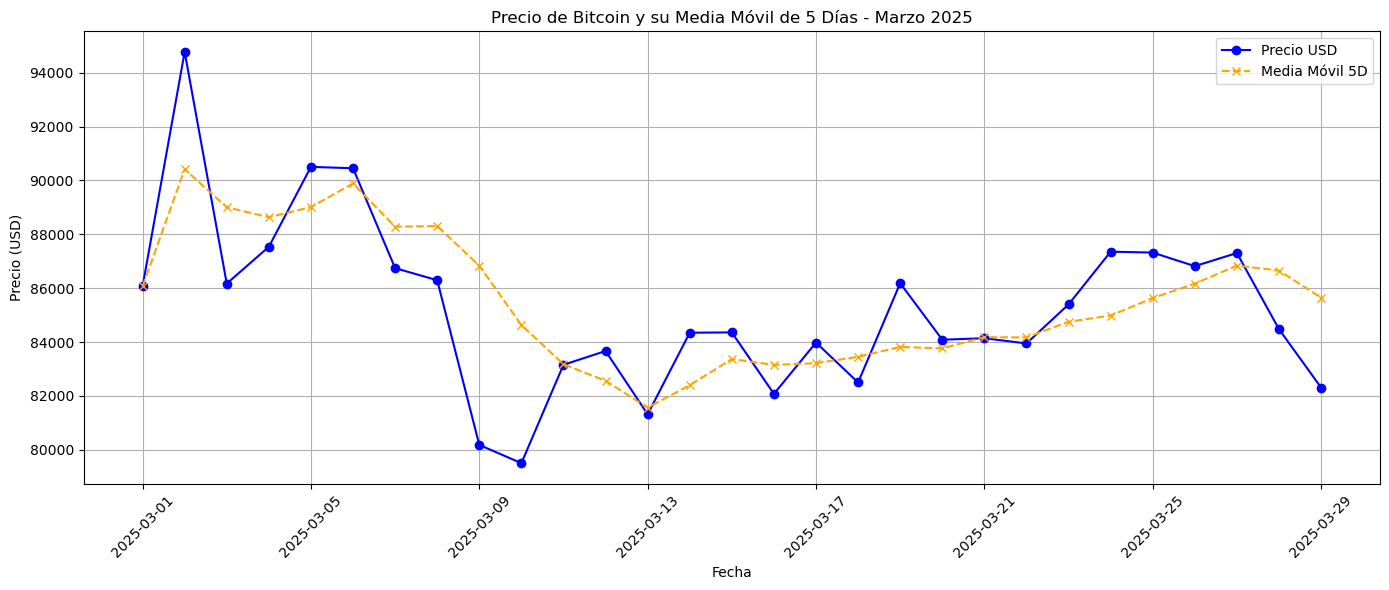

In [6]:
df_pandas = df_spark.toPandas()
plt.figure(figsize=(14, 6))
plt.plot(df_pandas["date"], df_pandas["price_usd"], label="Precio USD", color="blue", marker='o')
plt.plot(df_pandas["date"], df_pandas["moving_avg_5d"], label="Media Móvil 5D", color="orange", linestyle="--", marker='x')

plt.title("Precio de Bitcoin y su Media Móvil de 5 Días - Marzo 2025")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

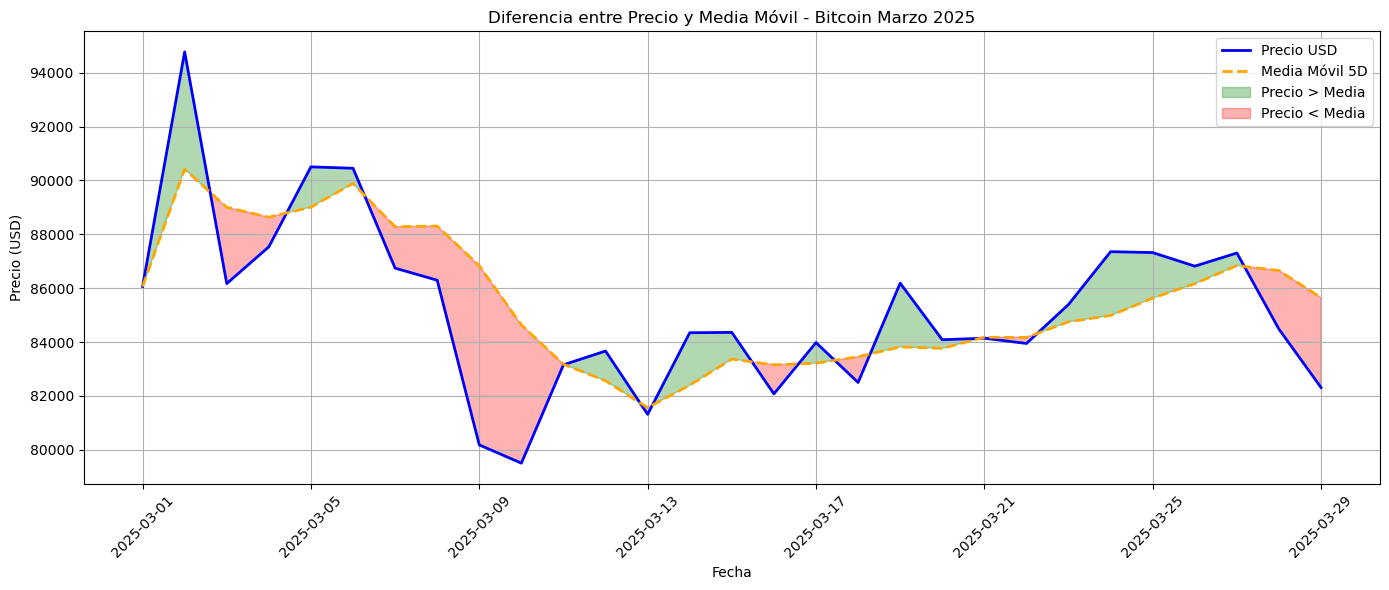

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(df_pandas["date"], df_pandas["price_usd"], label="Precio USD", color="blue", linewidth=2)
plt.plot(df_pandas["date"], df_pandas["moving_avg_5d"], label="Media Móvil 5D", color="orange", linestyle="--", linewidth=2)

# Área donde el precio está por encima de la media
plt.fill_between(df_pandas["date"], df_pandas["price_usd"], df_pandas["moving_avg_5d"],
                 where=(df_pandas["price_usd"] > df_pandas["moving_avg_5d"]),
                 interpolate=True, color='green', alpha=0.3, label='Precio > Media')

# Área donde el precio está por debajo de la media
plt.fill_between(df_pandas["date"], df_pandas["price_usd"], df_pandas["moving_avg_5d"],
                 where=(df_pandas["price_usd"] <= df_pandas["moving_avg_5d"]),
                 interpolate=True, color='red', alpha=0.3, label='Precio < Media')

plt.title("Diferencia entre Precio y Media Móvil - Bitcoin Marzo 2025")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

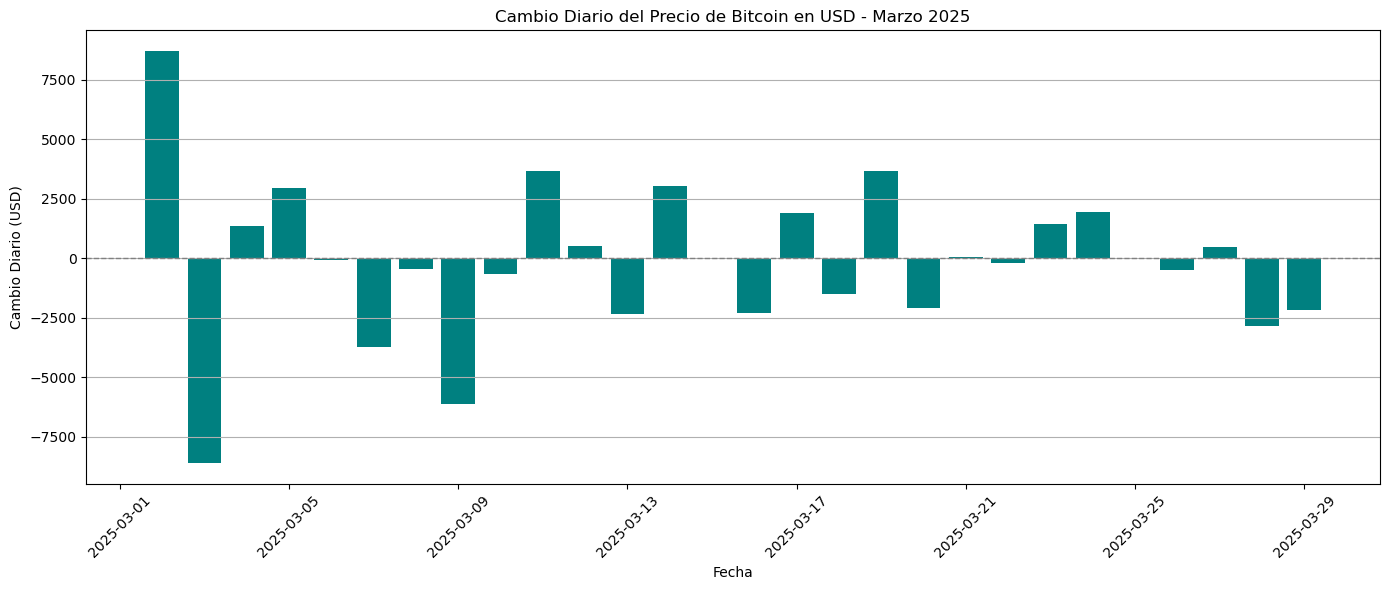

In [10]:
# Calcular el cambio absoluto diario en USD
df_pandas["daily_change_usd"] = df_pandas["price_usd"].diff()

# Graficar
plt.figure(figsize=(14, 6))
plt.bar(df_pandas["date"], df_pandas["daily_change_usd"], color="teal")

plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Cambio Diario del Precio de Bitcoin en USD - Marzo 2025")
plt.xlabel("Fecha")
plt.ylabel("Cambio Diario (USD)")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()